In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv('var3.txt')
data = data['val']
data

0      0.373841
1      0.336104
2      0.042975
3      0.197830
4      0.633059
         ...   
495    1.214944
496    0.037216
497    0.119659
498    0.099170
499    0.368402
Name: val, Length: 500, dtype: float64

In [3]:
sorted_data = data.sort_values()

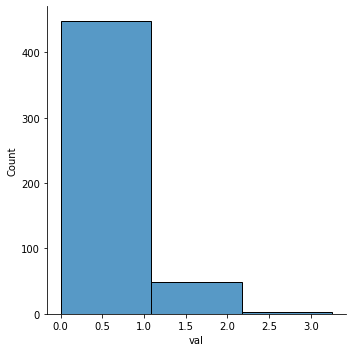

In [4]:
sns.displot(data, bins = 3)

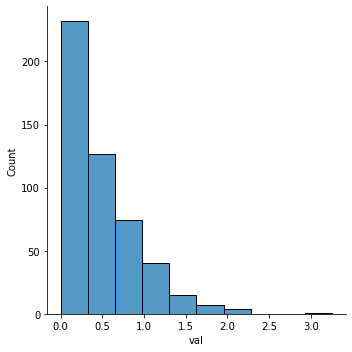

In [5]:
sns.displot(data, bins = 10)

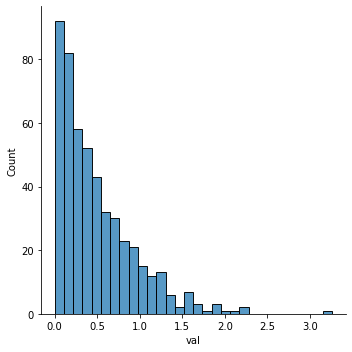

In [6]:
sns.displot(data, bins = 30)

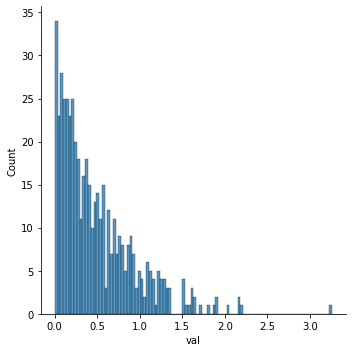

In [7]:
sns.displot(data ,bins = 100)

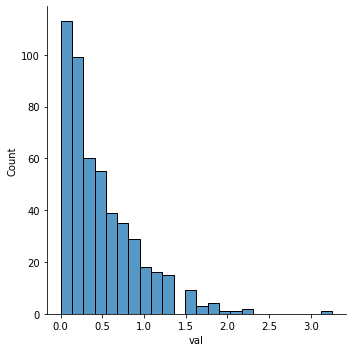

In [8]:
sns.displot(data) # bins = 24

<AxesSubplot:xlabel='val'>

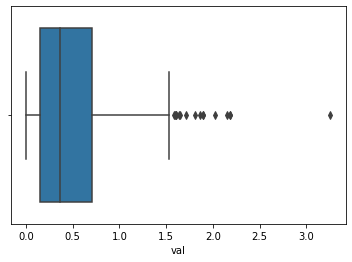

In [9]:
sns.boxplot(x = data)

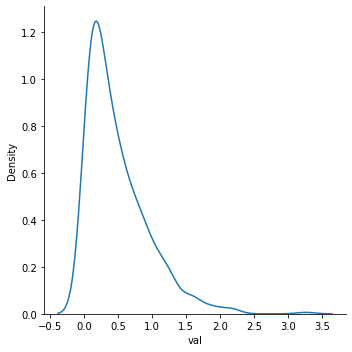

In [10]:
sns.displot(data, kind = 'kde') # kernel density estimation

### **Распределение похоже на экспоненциальное / Вейбулла**

In [11]:
data_mean = data.mean()
data_median = data.median()
data_var = data.var()
data_std = data.std()
data_skew = data.skew()
print('MEAN =',data_mean)
print('MEDIAN =', data_median)
print('VARIANCE =', data_var) # unbiased with N - 1 in denum
print('STD =', data_std)
print('SKEW =', data_skew )


#from scipy.stats import kurtosis

data_K = data.kurtosis()
print('KURTOSIS =',data_K)

print(data.min(), data.max())

MEAN = 0.4878172557716
MEDIAN = 0.36366430000000005
VARIANCE = 0.20095395861900042
STD = 0.4482788848685608
SKEW = 1.6124764853051805
KURTOSIS = 3.8729468745607796
0.0005915008 3.256096


In [12]:
data.skew()

1.6124764853051805

## Quartiles

In [13]:
print('q_0.25', data.quantile(q = 0.25))
print('q_0.75', data.quantile(q = 0.75))

q_0.25 0.150489325
q_0.75 0.7086685


In [14]:
from scipy.stats import ks_1samp
from scipy.stats import expon, exponweib

### 3-$\sigma$

In [15]:
data[(data >= data_mean - 3*data_std) & (data <= data_mean + 3*data_std)].size/data.size

0.984

In [16]:
n = len(data)
lambda_hat = 1/data.mean() - 1/(data.mean()*(n - 1))
print(ks_1samp(x = data, cdf = expon.cdf, args = (lambda_hat,)))
print(ks_1samp(x = data, cdf = expon.cdf, args = (1/data.mean(),)))
print(ks_1samp(x = data, cdf = expon.cdf, args = (data.mean(),)))

KstestResult(statistic=0.992, pvalue=0.0)
KstestResult(statistic=0.992, pvalue=0.0)
KstestResult(statistic=0.6144500814358068, pvalue=4.300788824002557e-182)


### К-С тест $p-value << 0.05$

### MLE for Weibull
$L(x,k) = \frac{\sum_{i=1}^nx_i^k\log(x)}{\sum_{i=1}^nx_i^k} - \frac{1}{k} - \overline{\log{X}}$       

$\frac{\delta L(x,k)}{\delta k} = \frac{\sum_{i = 1}^nx_i^k\log^2{x_i}}{\sum_{i = 1}^nx_i^k\log{x_i}} + \frac{1}{k^2}$

In [17]:
def num(X,k):
    return np.sum(np.log(X)*X**k)
def denum(X,k):
    return np.sum(X**k)
def dnum(X,k):
    return np.sum(np.log(X)**2*X**k)
def ddenum(X,k):
    return np.sum(np.log(X)*X**k)
def lh(X,k):
    return num(X,k)/denum(X,k) - 1/k - np.mean(np.log(X))
def dlh(X, k):
    return dnum(X,k)/ddenum(X,k) + 1/k**2

In [18]:
K = np.linspace(0.001,10)

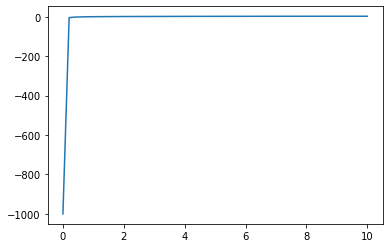

In [19]:
plt.plot(K, [lh(data,k) for k in K])

In [20]:
def Newton_method(data, k_0, eps = 10**(-3)):
    k_pprev = 0
    k_prev = k_0
    k_pprev = k_next = k_prev - lh(data, k_prev)/dlh(data, k_prev)
    while np.abs(k_prev - k_pprev) >= eps:
        k_next = k_prev - lh(data, k_prev)/dlh(data, k_prev)
        k_pprev = k_prev
        k_prev = k_next
    return k_next

In [21]:
k1 = Newton_method(data, k_0 = 10)
k2 = Newton_method(data, k_0 = 0.0001)
print(k1)
print(k2)

1.7516238594776348
0.00020000000093501247


In [22]:
def weibull_lambda(X,k):
    return (np.sum(X**k)/n)**(1/k)
def weibull_cdf(x,l,k):
    return 1 - np.exp(-(x/l)**k)

In [23]:
print(ks_1samp(x = data, cdf = weibull_cdf, args = (weibull_lambda(data,k1), k1)))
print(ks_1samp(x = data, cdf = weibull_cdf, args = (weibull_lambda(data,k2), k2)))

KstestResult(statistic=0.21661731444893095, pvalue=4.469807688492626e-21)
KstestResult(statistic=0.631666145208855, pvalue=8.096057040781993e-194)


In [24]:
l = weibull_lambda(data,1)
print(l, data.mean())
print(ks_1samp(x = data, cdf = weibull_cdf, args = (weibull_lambda(data,1), 1)))

0.4878172557716 0.4878172557716
KstestResult(statistic=0.029946044912314895, pvalue=0.7492787570901663)


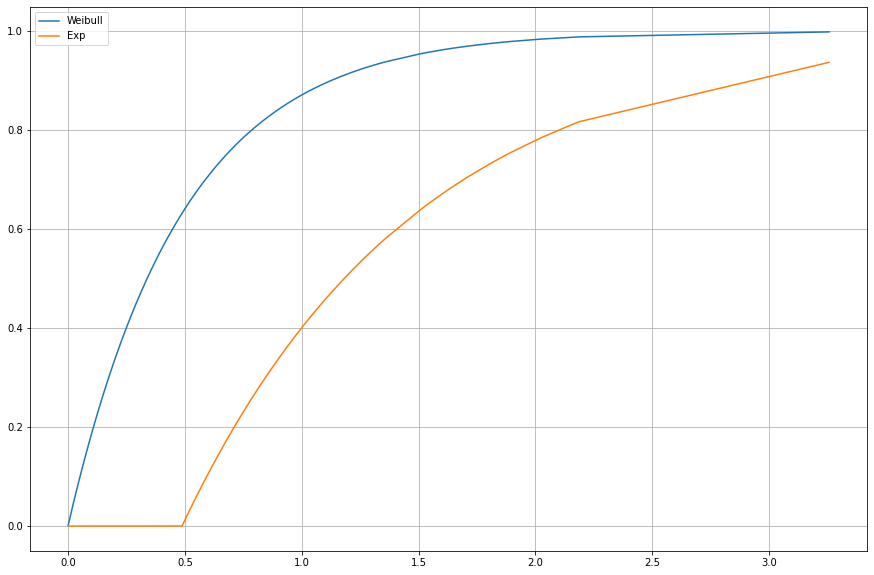

In [25]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
plt.plot(sorted_data,weibull_cdf(sorted_data,l,1), label = 'Weibull')
plt.plot(sorted_data, expon.cdf(sorted_data,l), label = 'Exp')
plt.legend()
plt.grid()

In [26]:
def expon_cdf(x, l):
    return 1 - np.exp(-l*x)

In [27]:
from scipy.stats import chisquare

In [28]:
print(chisquare(data))

Power_divergenceResult(statistic=205.56063600552758, pvalue=1.0)


In [29]:
print(ks_1samp(x = data, cdf = expon_cdf, args = (1/l,) ))

KstestResult(statistic=0.029946044912314895, pvalue=0.7492787570901663)


In [30]:
from statsmodels.stats.diagnostic import lilliefors
lilliefors(data, dist = 'exp')

(0.029946044912314895, 0.6150505527614514)

## Gaps

In [31]:
#np.random.seed(0)

In [32]:
amount = int(0.3 * 500)
gap_indexes = np.random.randint(low = 0, high = 500, size = amount)
gapdata = data.copy()
gapdata[gap_indexes] = None
gapdata

0      0.373841
1      0.336104
2      0.042975
3      0.197830
4      0.633059
         ...   
495    1.214944
496    0.037216
497    0.119659
498    0.099170
499         NaN
Name: val, Length: 500, dtype: float64

In [33]:
gap_indexes

array([ 88,  21, 212, 379,  24, 384, 475, 401,  53, 156, 321, 381,  90,
        87,  81,  30, 482, 216, 222, 392, 477, 491, 146, 449, 266, 313,
       270,  27, 330,  65, 222,  69, 472,  76, 421, 482, 344, 192, 403,
        60,  51,  55,  53, 384, 250, 273,  13, 155, 461, 374, 130, 171,
       215, 410,  79, 144, 202, 338, 391, 455, 408, 467,  67,   9, 429,
        89,  67, 318, 475, 171, 167,  25, 360, 141, 390, 427, 162, 408,
       124, 266,  33, 394, 118, 484, 248, 406, 346,  24, 494, 251, 265,
       188, 443, 221, 107, 286, 305, 260,  51, 271, 466, 480, 366, 486,
         8, 244, 253,  19,   6, 485, 250, 145, 195,  43,  82, 274, 192,
       314, 470, 191, 138, 327,  50, 119, 313, 486, 202, 476, 366, 409,
       444, 357, 160, 152, 223,  61, 499, 401, 241, 335,  64,  54, 257,
       217, 183, 470,  61, 466, 249,  22])

In [34]:
data_mean

0.4878172557716

In [35]:
gap_mean = gapdata.mean(skipna = True)
gap_variance = gapdata.var(skipna = True)
gap_std = gapdata.std(skipna = True)
gap_median = gapdata.median(skipna = True)
gap_skew = gapdata.skew(skipna = True)
gap_kurt = gapdata.kurtosis(skipna = True)
print('gap_mean',gap_mean)
print('gap_median',gap_median)
print('gap_variance',gap_variance)
print('gap_std', gap_std)
print('gap_skew', gap_skew)
print('gap_kurt', gap_kurt)
print(gapdata.min(),gapdata.max())

gap_mean 0.48105928032291106
gap_median 0.348182
gap_variance 0.20303541643779444
gap_std 0.4505945144337583
gap_skew 1.6808722916357253
gap_kurt 4.553588965688064
0.0005915008 3.256096


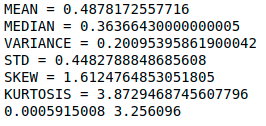

In [36]:
gap_amount = gapdata.isna().sum()
gap_amount

129

<AxesSubplot:xlabel='val', ylabel='Count'>

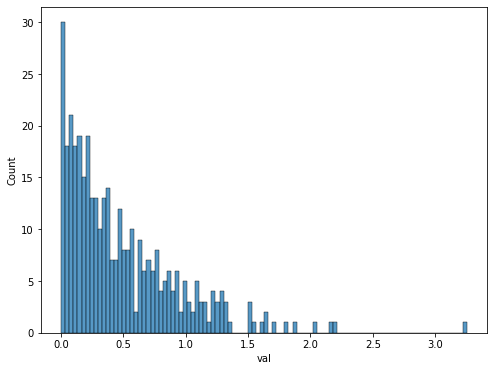

In [37]:
rcParams['figure.figsize'] = 8,6
sns.histplot(gapdata, bins = 100)

In [38]:
filled_data = gapdata.fillna(value = gap_mean)
filled_mean = filled_data.mean(skipna = True)
filled_variance = filled_data.var(skipna = True)
filled_std = filled_data.std(skipna = True)
filled_median = filled_data.median(skipna = True)
filled_skew = filled_data.skew(skipna = True)
filled_kurt = filled_data.kurtosis(skipna = True)
print('gap_mean',filled_mean)
print('gap_median',filled_median)
print('gap_variance',filled_variance)
print('gap_std', filled_std)
print('gap_skew', filled_skew)
print('gap_kurt', filled_kurt)
print(filled_data.min(),filled_data.max())

gap_mean 0.4810592803229111
gap_median 0.48105928032291106
gap_variance 0.1505473027695069
gap_std 0.3880042561229282
gap_skew 1.9492935556160982
gap_kurt 7.1592742052249925
0.0005915008 3.256096


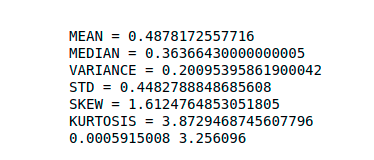

<AxesSubplot:xlabel='val', ylabel='Count'>

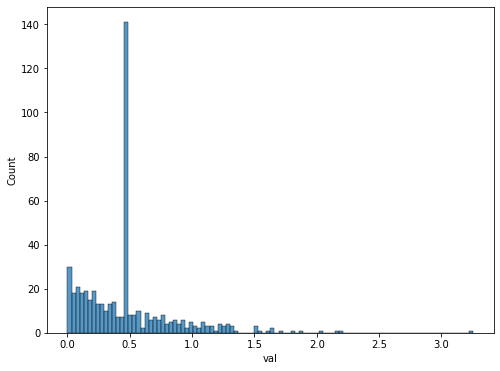

In [39]:
rcParams['figure.figsize'] = 8,6
sns.histplot(filled_data, bins = 100)

In [40]:
def mean(X,gap_amount):
    return np.sum(X)/(len(X) - gap_amount)
def variance(X,gap_amount):
    return np.sum((X - mean(X,gap_amount))**2)/(len(X) - gap_amount - 1)

In [41]:
print(mean(filled_data, gap_amount))
print(variance(filled_data, gap_amount))

0.6483278710551362
0.2408445805533953


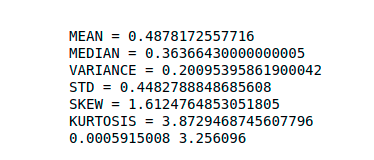

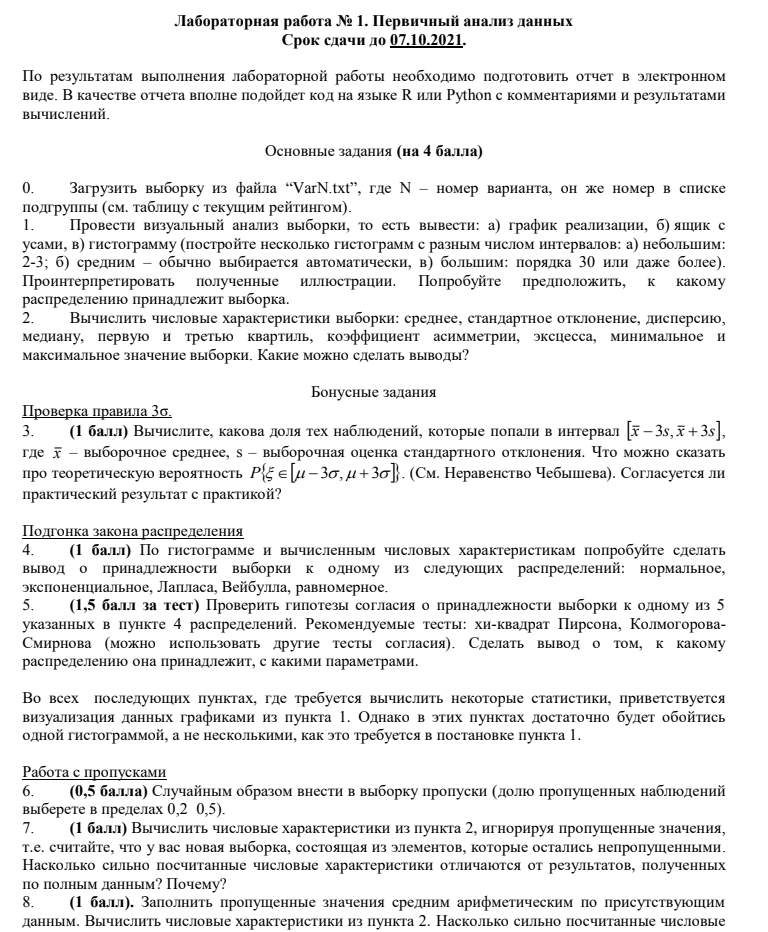
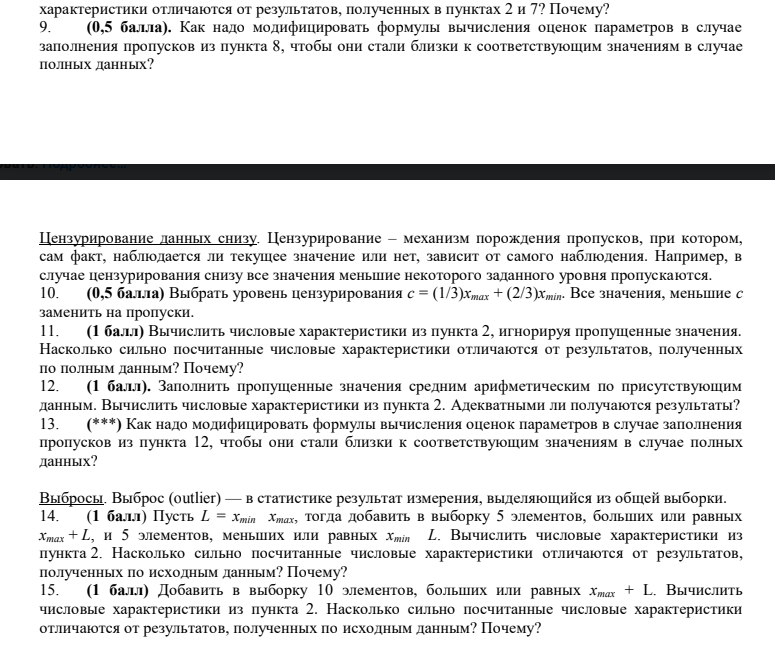

### https://docs.scipy.org/doc/scipy/reference/stats.mstats.html#statistical-tests